# Cosinor Regression Model used for 24-hours Window Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.ma import add
from CosinorPy import file_parser, cosinor, cosinor1, cosinor_nonlin
np.seterr(divide='ignore')
import scipy.signal as signal
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi
from scipy.optimize import curve_fit
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.stats import percentileofscore
from scipy.stats import circstd, circmean

import copy
import itertools
from random import sample
import os
import copy
from CosinorPy.helpers import df_add_row

### Data Preparation

In [2]:
def load_data(path):
    """Function used to parser the data using the file_parser method from the CosinorPy package"""
    df = pd.read_csv(path)
    df['Region start time'] = pd.to_datetime(df['Region start time'])
    df['date'] = df['Region start time'].dt.date
    df['hour'] = df['Region start time'].dt.hour
    df = df.drop('Unnamed: 0', axis=1)
    return df

In [3]:
pre_data = load_data("data/RNS_G_Pre_output.csv")
post_data = load_data("data/RNS_G_M1_output.csv")

In [16]:
def prepare_data(df):
    """Function used to prepare the data for Cosinor Regression"""
    df1 = df.copy()
    
    # Ensure date column is in datetime format
    df1['date'] = pd.to_datetime(df1['date'])

    # Compute 'week' column by calculating the number of days since the start date
    start_date = df1['date'].min()
    df1['week'] = ((df1['date'] - start_date).dt.days // 7) + 1
    df1['week'] = df1['week'].apply(lambda x: f"week{x}")

    # Add remaining columns
    df1['test'] = df1['week'].astype(str)
    df1['x'] = df1['hour']
    df1['y'] = df1["Pattern A Channel 2"]

    return df1

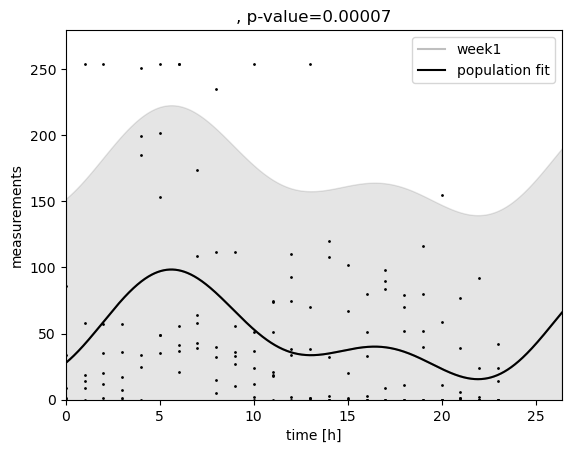

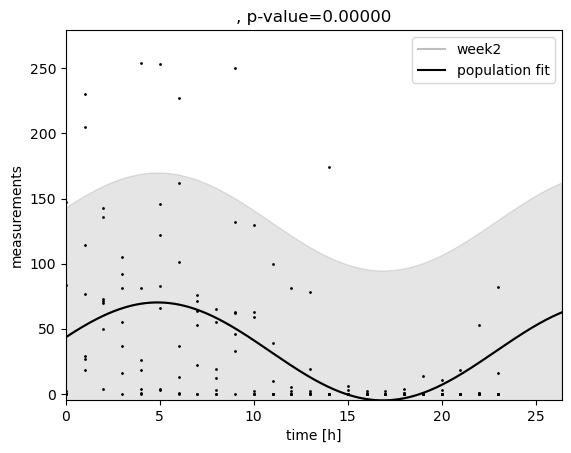

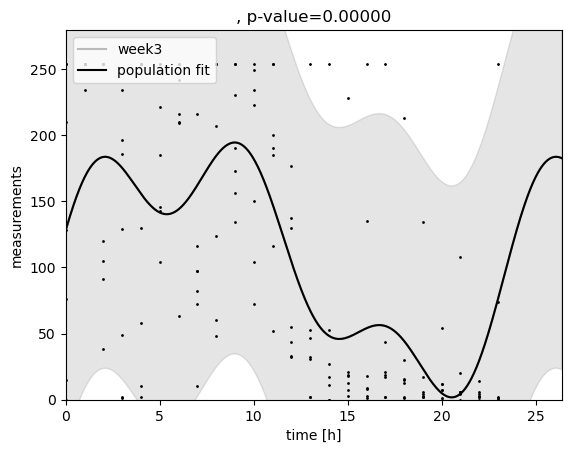

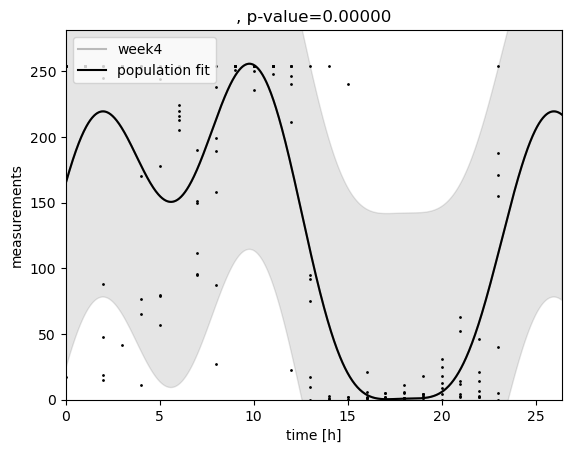

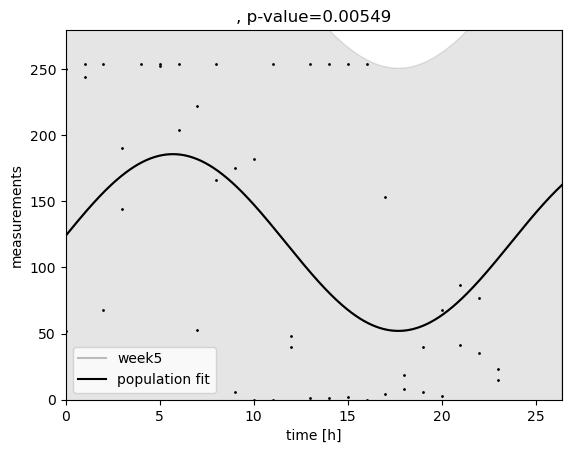

,test,period,n_components,p,q,p_reject,q_reject,RSS,amplitude,acrophase,...,resid_SE,mean(amplitude),p(amplitude),CI(amplitude),mean(acrophase),p(acrophase),CI(acrophase),mean(mesor),p(mesor),CI(mesor)
0,week1,24.0,2.0,6.517637e-05,9.776456e-05,0.930827,0.986624,5.847287e+05,41.447816,-1.471737,...,61.820356,41.447816,NaN,"[nan, <function nan_to_num at 0x106451620>]",-1.471737,NaN,"[nan, <function nan_to_num at 0x106451620>]",56.981309,NaN,"[nan, <function nan_to_num at 0x106451620>]"
1,week2,24.0,1.0,9.128059e-10,1.956013e-09,0.337844,0.639647,4.141173e+05,37.613657,-1.270474,...,50.097919,37.613657,NaN,"[nan, <function nan_to_num at 0x106451620>]",-1.270474,NaN,"[nan, <function nan_to_num at 0x106451620>]",32.613168,NaN,"[nan, <function nan_to_num at 0x106451620>]"
2,week3,24.0,3.0,7.771561e-16,2.914335e-15,0.036875,0.092187,1.012770e+06,96.336995,-2.352264,...,79.312649,96.336995,NaN,"[nan, <function nan_to_num at 0x106451620>]",-2.352264,NaN,"[nan, <function nan_to_num at 0x106451620>]",98.120730,NaN,"[nan, <function nan_to_num at 0x106451620>]"
3,week4,24.0,3.0,1.110223e-16,5.551115e-16,0.000741,0.003362,7.910524e+05,127.652121,-2.553527,...,70.095429,127.652121,NaN,"[nan, <function nan_to_num at 0x106451620>]",-2.553527,NaN,"[nan, <function nan_to_num at 0x106451620>]",128.054014,NaN,"[nan, <function nan_to_num at 0x106451620>]"
4,week5,24.0,1.0,5.494394e-03,5.922508e-03,0.951552,0.986624,4.116350e+05,66.807339,-1.496895,...,95.642278,66.807339,NaN,"[nan, <function nan_to_num at 0x106451620>]",-1.496895,NaN,"[nan, <function nan_to_num at 0x106451620>]",118.833418,NaN,"[nan, <function nan_to_num at 0x106451620>]"


In [17]:
df_results_pre_data = cosinor.population_fit_group(prepare_data(pre_data), n_components = [1,2,3], period=24, plot=False)
df_best_models_pre_data = cosinor.get_best_models_population(prepare_data(pre_data), df_results_pre_data, n_components = [1,2,3])
cosinor.plot_df_models_population(prepare_data(pre_data), df_best_models_pre_data)
df_best_models_pre_data

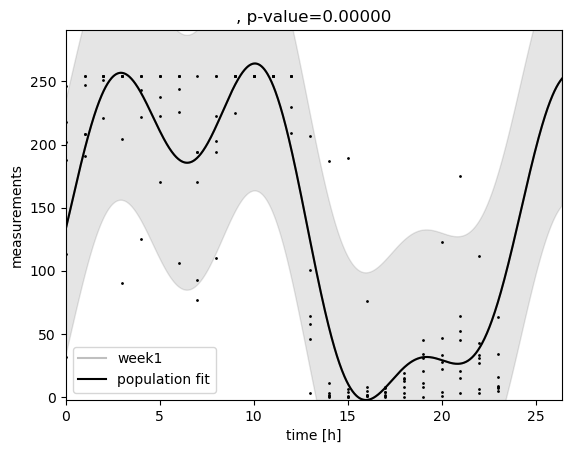

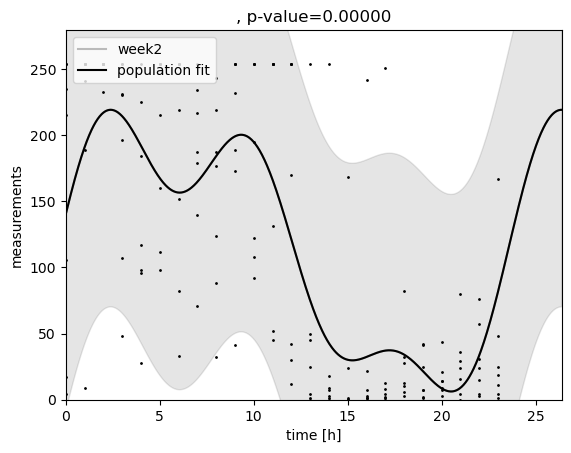

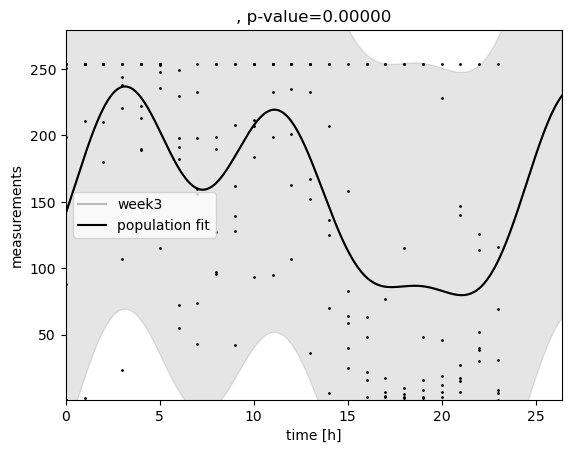

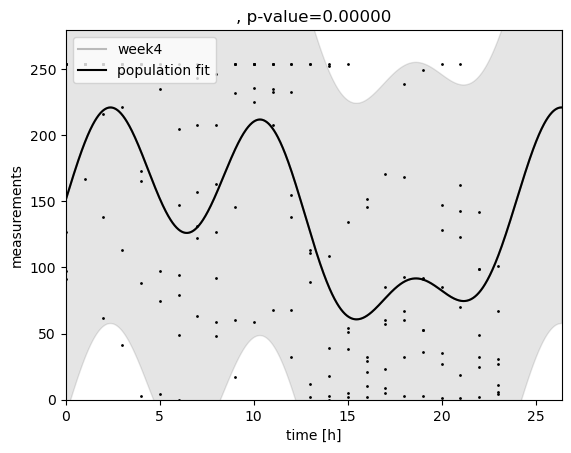

,test,period,n_components,p,q,p_reject,q_reject,RSS,amplitude,acrophase,...,resid_SE,mean(amplitude),p(amplitude),CI(amplitude),mean(acrophase),p(acrophase),CI(acrophase),mean(mesor),p(mesor),CI(mesor)
0,week1,24.0,3.0,1.110223e-16,2.220446e-16,0.000425,0.001701,3.607911e+05,133.289513,-2.629000,...,49.882003,133.289513,NaN,"[nan, <function nan_to_num at 0x106451620>]",-2.629000,NaN,"[nan, <function nan_to_num at 0x106451620>]",130.918901,NaN,"[nan, <function nan_to_num at 0x106451620>]"
1,week2,24.0,3.0,1.110223e-16,2.220446e-16,0.701174,0.840226,8.797219e+05,106.471555,-0.628947,...,73.919626,106.471555,NaN,"[nan, <function nan_to_num at 0x106451620>]",-0.628947,NaN,"[nan, <function nan_to_num at 0x106451620>]",112.701954,NaN,"[nan, <function nan_to_num at 0x106451620>]"
2,week3,24.0,3.0,6.352863e-11,1.045802e-10,0.994025,0.994025,1.116787e+06,78.629529,-0.830211,...,83.286047,78.629529,NaN,"[nan, <function nan_to_num at 0x106451620>]",-0.830211,NaN,"[nan, <function nan_to_num at 0x106451620>]",158.315290,NaN,"[nan, <function nan_to_num at 0x106451620>]"
3,week4,24.0,3.0,6.972012e-11,1.045802e-10,0.516073,0.688097,1.057331e+06,80.092538,-0.616369,...,81.038711,80.092538,NaN,"[nan, <function nan_to_num at 0x106451620>]",-0.616369,NaN,"[nan, <function nan_to_num at 0x106451620>]",140.843238,NaN,"[nan, <function nan_to_num at 0x106451620>]"


In [19]:
df_results_post_data = cosinor.population_fit_group(prepare_data(post_data), n_components = [1,2,3], period=24, plot=False)
df_best_models_post_data = cosinor.get_best_models_population(prepare_data(pre_data), df_results_post_data, n_components = [1,2,3])
cosinor.plot_df_models_population(prepare_data(post_data), df_best_models_post_data)
df_best_models_post_data

### Statistics Analysis

This section includes the plots and analysis for the test statistics derived from the population cosinor fitting process.

In [22]:
df_best_models_pre_data
df_best_models_post_data

,test,period,n_components,p,q,p_reject,q_reject,RSS,amplitude,acrophase,...,resid_SE,mean(amplitude),p(amplitude),CI(amplitude),mean(acrophase),p(acrophase),CI(acrophase),mean(mesor),p(mesor),CI(mesor)
0,week1,24.0,3.0,1.110223e-16,2.220446e-16,0.000425,0.001701,3.607911e+05,133.289513,-2.629000,...,49.882003,133.289513,NaN,"[nan, <function nan_to_num at 0x106451620>]",-2.629000,NaN,"[nan, <function nan_to_num at 0x106451620>]",130.918901,NaN,"[nan, <function nan_to_num at 0x106451620>]"
1,week2,24.0,3.0,1.110223e-16,2.220446e-16,0.701174,0.840226,8.797219e+05,106.471555,-0.628947,...,73.919626,106.471555,NaN,"[nan, <function nan_to_num at 0x106451620>]",-0.628947,NaN,"[nan, <function nan_to_num at 0x106451620>]",112.701954,NaN,"[nan, <function nan_to_num at 0x106451620>]"
2,week3,24.0,3.0,6.352863e-11,1.045802e-10,0.994025,0.994025,1.116787e+06,78.629529,-0.830211,...,83.286047,78.629529,NaN,"[nan, <function nan_to_num at 0x106451620>]",-0.830211,NaN,"[nan, <function nan_to_num at 0x106451620>]",158.315290,NaN,"[nan, <function nan_to_num at 0x106451620>]"
3,week4,24.0,3.0,6.972012e-11,1.045802e-10,0.516073,0.688097,1.057331e+06,80.092538,-0.616369,...,81.038711,80.092538,NaN,"[nan, <function nan_to_num at 0x106451620>]",-0.616369,NaN,"[nan, <function nan_to_num at 0x106451620>]",140.843238,NaN,"[nan, <function nan_to_num at 0x106451620>]"
